## import packages

In [1]:
import netneurotools as nnt
from scipy.stats._stats_py import _chk2_asarray
import shutil

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pandas as pd # for creation of data frames
import numpy as np #
import pyls # PLS: behavioral and mean-centered
import seaborn as sns
import nibabel as nib # for loading niftis etc. as arrays
import matplotlib.pyplot as plt # for plotting data
#the output of plotting commands is displayed inline, directly below the code cell that produced it
%matplotlib inline 
import os,glob
from nilearn import plotting, input_data, image #for plotting & working with niftis

import pathlib

###################### update path!! #####################################
base_path = '/root_dir/' ####
##########################################################################

#import qBOLD functions
#import sys
#sys.path.append(os.path.join(base_path + 'scripts/'))
#import mqBOLD_functions as qB


### define FSL directories ######################################################
os.environ["FSLDIR"]='/usr/share/fsl/5.0'
os.environ["FSLOUTPUTTYPE"]='NIFTI_GZ'
os.environ["FSLTCLSH"]='/usr/bin/tclsh'
os.environ["FSLWISH"]='/usr/bin/wish'
os.environ["FSLMULTIFILEQUIT"]="True"
os.environ["LD_LIBRARY_PATH"]='/usr/share/fsl/5.0:/usr/lib/fsl/5.0'
#################################################################################

## define variables (please check!!)

In [2]:
data_dir = base_path + 'data/'
derivatives_dir = data_dir + 'derivatives'
raw_dir = data_dir + 'rawdata'
results_dir = base_path + 'results'
MNI_2mm_brain = derivatives_dir + '/MNI152_T1_2mm_brain.nii.gz'

sns.set_style("whitegrid")

coords=(-15, 0, 15, 30, 45, 60, 75, 90)

In [3]:
## Please which OEF / R2' / CMRO2 version to use ##
###################################################

#CMRO2_mode = 'orig' ## orig = CMRO2 maps NOT corrected for CBV changes, only CMRO2 maps of subj > 55 in CALC condition are corrected for CBV increases
CMRO2_mode = 'corrected' ## CMRO2 CALC maps corrected for CBV changes (but MEM maps are not corrected)

## Please specify task & baseline ##
####################################

baseline='rest'
#baseline='control'
task='calc'
#task='mem'
conds = [baseline, task]
contrast=task+baseline

## Please specify subject list##
################################

if baseline == 'control' and task == 'calc':
    #N=40
    sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68]
else: #N=30, without p053
    sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55]

N_subj = str(len(sids))


## Fig. S2B (use with CALC - REST contrast!)

sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055


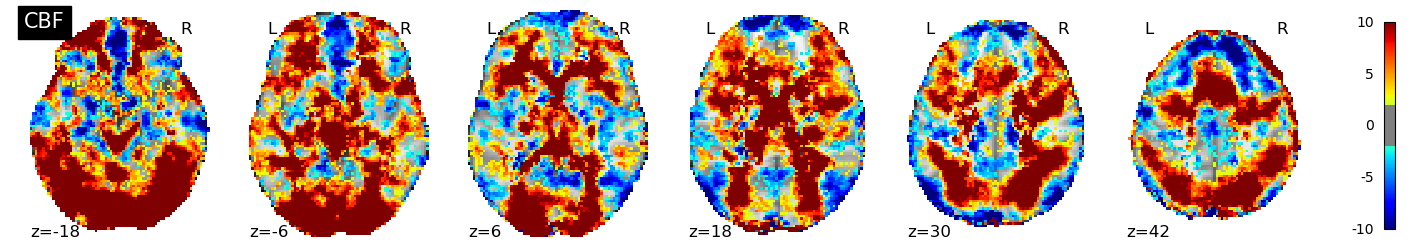

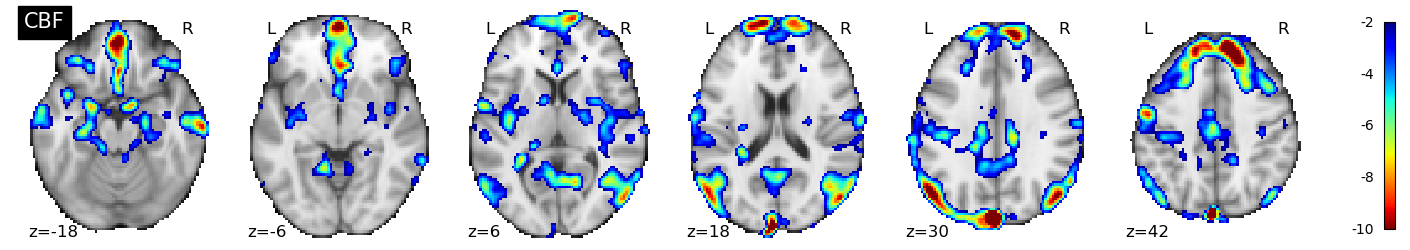

In [4]:
##########################################################
## please select which parameters you want to look at! ##
##########################################################

## get MNI brain mask
MNI_2mm = os.path.join(data_dir, 'derivatives', 'MNI152_T1_2mm.nii.gz')
MNI_2mm_brain = os.path.join(data_dir, 'derivatives', 'MNI152_T1_2mm_brain.nii.gz')
MNI_2mm_mask = os.path.join(data_dir, 'derivatives', 'MNI152_T1_2mm_brain_mask.nii.gz')
! fslmaths {MNI_2mm_brain} -bin {MNI_2mm_mask}

masker_brain = input_data.NiftiMasker(mask_img=MNI_2mm_mask)

par_map = np.zeros(shape=(91,109,91,len(sids))) #shape = MNI, 4D = length(sids)
    
for i, ID in enumerate(sids): #loop over subjects
    sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
    print(sub)

    dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')

    par_nii_task =  os.path.join(dir_qmri_deriv, sub + '_task-'+task+'_space-MNI152_cbf.nii.gz')
    par_nii_base =  os.path.join(dir_qmri_deriv, sub + '_task-'+baseline+'_space-MNI152_cbf.nii.gz')

    par_values_task = np.array(nib.load(par_nii_task).dataobj)
    par_values_base = np.array(nib.load(par_nii_base).dataobj)
    percchange = (par_values_task - par_values_base) / par_values_base * 100
    par_map[:, :, :, i] = percchange

            

## median per voxel, across subjects
par_map_median = np.nanmedian(par_map, axis=3)
par_map_median_nii = nib.Nifti1Image(par_map_median, (nib.load(MNI_2mm_brain).affine))

##brain-mask and turn into nifti 
cbf_map_arr = masker_brain.fit_transform(par_map_median_nii)
cbf_map_nii = masker_brain.inverse_transform(cbf_map_arr)
nib.save(cbf_map_nii, results_dir + '/N' + N_subj + '_median_percchange_CBF_' + contrast + '.nii.gz')
percchange_CBF_nii = results_dir + '/N' + N_subj + '_median_percchange_CBF_' + contrast + '.nii.gz'

## turn into nifti and  plot            
plot=plotting.plot_img(percchange_CBF_nii,  bg_img=MNI_2mm_brain, threshold = 2,  vmin = -10, vmax = 10, 
                       cmap='jet', display_mode='z', cut_coords = (-18, -6, 6, 18, 30, 42), colorbar=True, title='CBF')

## only negative values
##CBF
cbf_map_nii_neg = results_dir + '/N' + N_subj + '_median_percchange_CBF_negative.nii.gz'
! fslmaths {percchange_CBF_nii} -uthr {0}  {cbf_map_nii_neg}
percchange_CBF_smooth_nifti =  results_dir + '/N' + N_subj + '_median_percchange_CBF_negative_smooth.nii.gz'
##smoothing kernel of approx 5 FWHM
! fslmaths {cbf_map_nii_neg} -s 2.12 {percchange_CBF_smooth_nifti}
plot=plotting.plot_img(percchange_CBF_smooth_nifti,  bg_img=MNI_2mm_brain, threshold = 2,  vmin = -10, vmax = -2, 
                       cmap='jet_r', display_mode='z', cut_coords = (-18, -6, 6, 18, 30, 42), colorbar=True, title='CBF')
plot=plotting.plot_img(percchange_CBF_smooth_nifti,  bg_img=MNI_2mm_brain, threshold = 2,  vmin = -10, vmax = -2, 
                       cmap='jet_r', display_mode='z', cut_coords = (-18, -6, 6, 18, 30, 42), colorbar=True,
                      output_file= results_dir + '/median_percchange_CBF_negative.png')

## Fig S2A

### Find clusters with maximum CBF response (pos & neg)

In [ ]:
from IPython.display import Image
from nilearn import datasets, image
from atlasreader import create_output

func_BSR_cluster_thr_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+'.nii.gz'
inverse_MNI_affine = np.linalg.inv(nib.load(func_BSR_cluster_thr_nii).affine)

results_dir_CBF = results_dir + '/N' + N_subj + 'CBF_peaks'

##BSR image 
BSR_cluster_thr_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cbf_clusterBSR'+contrast+'.nii.gz'
plot = plotting.plot_img(BSR_cluster_thr_nii, bg_img=MNI_2mm_brain, cmap=BlueRed,threshold=0, vmin=-5, vmax=5, display_mode='z', cut_coords=coords)



## create cluster output with atlasreader
create_output(BSR_cluster_thr_nii, cluster_extent=100, outdir= results_dir_CBF)

## this csv file is automatically created via atlasreader
CBF_pd = pd.read_csv(results_dir + '/N' + N_subj + 'CBF_peaks/N' + N_subj +'_BSR_meanPLS_cbf_clusterBSR'+contrast+'_peaks.csv')
#Image(results_dir + '/N' + N_subj + 'CBF_peaks/N' + N_subj +'_BSR_meanPLS_CBF_'+contrast+'.png')

## create spheres
for ROI in CBF_pd['cluster_id']:
    ## create points
    ROI_nii = results_dir_CBF + '/'+str(ROI)+'.nii.gz'
    x=CBF_pd['peak_x'][ROI-1]
    y=CBF_pd['peak_y'][ROI-1]
    z=CBF_pd['peak_z'][ROI-1]
    coordinates = image.coord_transform(x,y,z, inverse_MNI_affine)
    ! fslmaths {MNI_2mm} -mul 0 -add 1 -roi {coordinates[0]} 1 {coordinates[1]} 1 {coordinates[2]} 1 0 1 {ROI_nii} -odt float
    
    ##create spheres
    ROI_sphere = results_dir_CBF + '/'+str(ROI)+'_sphere.nii.gz'
    ! fslmaths {ROI_nii} -kernel sphere 5 -fmean {ROI_sphere} -odt float

    ## binarize
    ROI_bin = results_dir_CBF + '/'+str(ROI)+'_sphere_bin.nii.gz'
    ! fslmaths {ROI_sphere} -bin {ROI_bin}

    plot=plotting.plot_img(ROI_bin,  bg_img=MNI_2mm_brain, threshold = 0, display_mode='z',cut_coords=coords, cmap='hsv', colorbar=True, title='ROI'+str(ROI))


### From all clusters, manually select those with maximum values (both pos & neg. separately) 

### positive clusters

In [ ]:
## look up in csv file with peaks to select! 9 regions
masks_pos = [results_dir_CBF + '/1_sphere_bin.nii.gz', 
             results_dir_CBF + '/2_sphere_bin.nii.gz',
            results_dir_CBF + '/3_sphere_bin.nii.gz',
            results_dir_CBF + '/4_sphere_bin.nii.gz',
            results_dir_CBF + '/5_sphere_bin.nii.gz',
            results_dir_CBF + '/9_sphere_bin.nii.gz',
            results_dir_CBF + '/10_sphere_bin.nii.gz', 
            results_dir_CBF + '/11_sphere_bin.nii.gz',
            results_dir_CBF + '/15_sphere_bin.nii.gz']


parameters = ['cbf', 'cmro2']

df_percchange_median = pd.DataFrame(columns=["ID","parameter", "ROI", "percchange"])


for par in parameters: 
    print(par)
    for m, mask in enumerate(masks_pos):
        #masker = input_data.NiftiMasker(mask_img = mask) 
        #mask_img=masker.fit_transform(mask)
        mask_arr = np.array(nib.load(mask).dataobj)
    
        for i, ID in enumerate(sids): #loop over subjects
            sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
            print(sub)
            dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')

            if par != 'cmro2':
                par_nii_task =  os.path.join(dir_qmri_deriv, sub + '_task-'+task+'_space-MNI152_'+par+'.nii.gz')
                par_nii_base =  os.path.join(dir_qmri_deriv, sub + '_task-'+baseline+'_space-MNI152_'+par+'.nii.gz')
            if par =='cmro2':
                if task == 'calc':
                    par_nii_task =  dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_desc-CBV_' + par + '.nii.gz'
                if task !='calc':
                    par_nii_task =  dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_desc-orig_' + par + '.nii.gz'   
                par_nii_base =  dir_qmri_deriv +  '/' + sub + '_task-' + baseline + '_space-MNI152_desc-orig_' + par + '.nii.gz'     

            par_values_task = np.array(nib.load(par_nii_task).dataobj)
            par_values_base = np.array(nib.load(par_nii_base).dataobj)
            percchange_arr = (par_values_task - par_values_base) / par_values_base * 100


            ## median with mask, for each subject    
            percchange_median = np.nanmedian(percchange_arr[mask_arr>0])
                            
            new_row = {'ID':ID, 'parameter':par, 'ROI': 'ROI' + str(m+1), 'percchange':percchange_median}
            df_percchange_median = df_percchange_median.append(new_row, ignore_index = True)
            
            
## calculate n-factors
CMRO2_median_pos = np.zeros(9)
CBF_median_pos = np.zeros(9)
for f in range(1,10):
    ROI_name='ROI'+str(f)
    CMRO2_median_pos[f-1] = np.nanmedian(df_percchange_median.query(f"parameter=='cmro2' & ROI=='{ROI_name}'")['percchange'].values)
    CBF_median_pos[f-1] = np.nanmedian(df_percchange_median.query(f"parameter=='cbf' & ROI=='{ROI_name}'")['percchange'].values)
n_factors_pos = CBF_median_pos/CMRO2_median_pos


In [ ]:
## plot all within one image

masks_pos = [results_dir_CBF + '/1_sphere_bin.nii.gz', 
             results_dir_CBF + '/2_sphere_bin.nii.gz',
            results_dir_CBF + '/3_sphere_bin.nii.gz',
            results_dir_CBF + '/4_sphere_bin.nii.gz',
            results_dir_CBF + '/5_sphere_bin.nii.gz',
            results_dir_CBF + '/9_sphere_bin.nii.gz',
            results_dir_CBF + '/10_sphere_bin.nii.gz', 
            results_dir_CBF + '/11_sphere_bin.nii.gz',
            results_dir_CBF + '/15_sphere_bin.nii.gz']

all_pos_CBF_ROIs = results_dir_CBF+ '/CBF_pos_9ROIS.nii.gz'
! fslmaths {masks_pos[0]} -add {masks_pos[1]} -add {masks_pos[2]} -add {masks_pos[3]} -add {masks_pos[4]} -add {masks_pos[5]} -add {masks_pos[6]} -add {masks_pos[7]} -add {masks_pos[8]} {all_pos_CBF_ROIs}
plot=plotting.plot_img(all_pos_CBF_ROIs,bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap='hsv', cut_coords=[-15, -10, 25, 30, 35, 50], colorbar=True)
plot=plotting.plot_img(all_pos_CBF_ROIs,bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap='hsv', cut_coords=[-15, -10, 25, 30, 35, 50], colorbar=True,
                      output_file = results_dir_CBF + '/all_pos_spheres.png')


## plot all in a row to identify
for m, mask in enumerate(masks_pos):
    plot=plotting.plot_img(mask,bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap='hsv', colorbar=True, title=str(m+1))

#### plot as boxplots

In [ ]:
##plot as barplot ##
fontsize=50
sns.set_style("whitegrid")

Red_palette=["navajowhite", "darkorange", "firebrick"]
Red_palette=["darkorange", "firebrick"]

fig, ax1= plt.subplots(1, figsize=(25,10))

ax1 = sns.barplot(x="ROI", y="percchange", hue="parameter", data=df_percchange_median, estimator=np.median, ci=95, capsize=.07, n_boot=2000, errwidth=3,
                 saturation=0.8, alpha=0.8, palette=Red_palette)
ax1 = sns.stripplot(data = df_percchange_median, x="ROI", y="percchange", hue="parameter",  palette=Red_palette, dodge=True,marker='o', 
                    size=8, alpha=0.9)
ax1.set_ylim(-25, 65)
ax1.set_yticks([-20, -10, 0, 10, 20, 30, 40, 50, 60])
ax1.set_ylabel('change [%]', fontsize=fontsize+10)  # we already handled the x-label with ax1
#ax1.tick_params(axis='y', labelcolor='firebrick')
#ax1.legend(fontsize=fontsize-5,loc="upper right")
ax1.legend([], [], frameon=False)


#set x-tick and y-ticke label size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(fontsize)
#for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
#    label.set_fontsize(fontsize)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

fig.savefig(results_dir_CBF + '/positive_peaks_CBF_CMRO2.png', dpi=300)

### negative clusters

In [ ]:
masks_neg = [results_dir_CBF + '/6_sphere_bin.nii.gz', 
             results_dir_CBF + '/7_sphere_bin.nii.gz',
            results_dir_CBF + '/8_sphere_bin.nii.gz',
            results_dir_CBF + '/12_sphere_bin.nii.gz',
            results_dir_CBF + '/16_sphere_bin.nii.gz',
            results_dir_CBF + '/17_sphere_bin.nii.gz',
            results_dir_CBF + '/19_sphere_bin.nii.gz']

parameters = ['cbf', 'cmro2']


df_percchange_median = pd.DataFrame(columns=["ID","parameter", "ROI", "percchange"])


for par in parameters: 
    print(par)
    for m, mask in enumerate(masks_neg):
        #masker = input_data.NiftiMasker(mask_img = mask) 
        #mask_img=masker.fit_transform(mask)
        mask_arr = np.array(nib.load(mask).dataobj)
    
        for i, ID in enumerate(sids): #loop over subjects
            sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
            print(sub)
            dir_qmri_deriv = os.path.join(derivatives_dir, sub, 'qmri')

            if par != 'cmro2':
                par_nii_task =  os.path.join(dir_qmri_deriv, sub + '_task-'+task+'_space-MNI152_'+par+'.nii.gz')
                par_nii_base =  os.path.join(dir_qmri_deriv, sub + '_task-'+baseline+'_space-MNI152_'+par+'.nii.gz')
            if par =='cmro2':
                if task == 'calc':
                    par_nii_task =  dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_desc-CBV_' + par + '.nii.gz'
                if task !='calc':
                    par_nii_task =  dir_qmri_deriv +  '/' + sub + '_task-' + task + '_space-MNI152_desc-orig_' + par + '.nii.gz'   
                par_nii_base =  dir_qmri_deriv +  '/' + sub + '_task-' + baseline + '_space-MNI152_desc-orig_' + par + '.nii.gz'     

            par_values_task = np.array(nib.load(par_nii_task).dataobj)
            par_values_base = np.array(nib.load(par_nii_base).dataobj)
            percchange_arr = (par_values_task - par_values_base) / par_values_base * 100


            ## median with mask, for each subject    
            percchange_median = np.nanmedian(percchange_arr[mask_arr>0])
                            
            new_row = {'ID':ID, 'parameter':par, 'ROI': 'ROI' + str(m+1), 'percchange':percchange_median}
            df_percchange_median = df_percchange_median.append(new_row, ignore_index = True)
            
## calculate n-factors
CMRO2_median_neg = np.zeros(9)
CBF_median_neg = np.zeros(9)
for f in range(1,10):
    ROI_name='ROI'+str(f)
    CMRO2_median_neg[f-1] = np.nanmedian(df_percchange_median.query(f"parameter=='cmro2' & ROI=='{ROI_name}'")['percchange'].values)
    CBF_median_neg[f-1] = np.nanmedian(df_percchange_median.query(f"parameter=='cbf' & ROI=='{ROI_name}'")['percchange'].values)
n_factors_neg = CBF_median_neg/CMRO2_median_neg

In [ ]:
## plot all within one image

masks_neg = [results_dir_CBF + '/6_sphere_bin.nii.gz', 
             results_dir_CBF + '/7_sphere_bin.nii.gz',
            results_dir_CBF + '/8_sphere_bin.nii.gz',
            results_dir_CBF + '/12_sphere_bin.nii.gz',
            results_dir_CBF + '/16_sphere_bin.nii.gz',
            results_dir_CBF + '/17_sphere_bin.nii.gz',
            results_dir_CBF + '/19_sphere_bin.nii.gz']

all_neg_CBF_ROIs = results_dir_CBF+ '/CBF_neg_7ROIS.nii.gz'
! fslmaths {masks_neg[0]} -add {masks_neg[1]} -add {masks_neg[2]} -add {masks_neg[3]} -add {masks_neg[4]} -add {masks_neg[5]} -add {masks_neg[6]} {all_neg_CBF_ROIs}
plot=plotting.plot_img(all_neg_CBF_ROIs,bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap='jet', colorbar=True)
plot=plotting.plot_img(all_neg_CBF_ROIs,bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap='jet', cut_coords=[-10, 15, 25, 30, 40], colorbar=True,
                      output_file = results_dir_CBF + '/all_neg_spheres.png')

## plot all in a row to identify
for m, mask in enumerate(masks_neg):
    plot=plotting.plot_img(mask,bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap='jet', colorbar=True, title=str(m+1))

In [ ]:
##plot as barplot ##
fontsize=50
sns.set_style("whitegrid")

#Red_palette=["navajowhite", "darkorange", "firebrick"]
Blue_palette=["dodgerblue", "mediumblue"]

fig, ax1= plt.subplots(1, figsize=(25,10))

ax1 = sns.barplot(x="ROI", y="percchange", hue="parameter", data=df_percchange_median, estimator=np.median, ci=95, capsize=.07, n_boot=2000, errwidth=3,
                 saturation=0.8, alpha=0.8, palette=Blue_palette)
ax1 = sns.stripplot(data = df_percchange_median, x="ROI", y="percchange", hue="parameter",  palette=Blue_palette, dodge=True,marker='o', 
                    size=8, alpha=0.9)
ax1.set_ylim(-35, 20)
ax1.set_yticks([ -30, -20, -10, 0, 10, 20])
ax1.set_ylabel('change [%]', fontsize=fontsize+10)  # we already handled the x-label with ax1
ax1.tick_params(axis='y')
#ax1.legend(fontsize=fontsize-5,loc="lower right")
ax1.legend([], [], frameon=False)


#set x-tick and y-ticke label size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(fontsize)
#for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
#    label.set_fontsize(fontsize)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()

fig.savefig(results_dir_CBF + '/negative_peaks_CBF_CMRO2.png', dpi=300)

## plot n-factor

In [ ]:
fontsize = 25
plt.rcParams['legend.title_fontsize'] = 'xx-large'

ROIs_pos = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
ROIs_neg = ['1', '2', '3', '4', '5', '6', '7']

fig, ax= plt.subplots(1, figsize=(7, 7))

ax.scatter(CMRO2_median_pos, CBF_median_pos, color='darkorange', s=80)
for i, txt in enumerate(ROIs_pos):
    ax.annotate(txt, (CMRO2_median_pos[i], CBF_median_pos[i]+0.7), fontsize=20, color='darkorange')

ax.scatter(CMRO2_median_neg, CBF_median_neg, color='dodgerblue', s=80)
for i, txt in enumerate(ROIs_neg):
    ax.annotate(txt, (CMRO2_median_neg[i], CBF_median_neg[i]+0.7), fontsize=20, color='dodgerblue')

ax.set_xlabel('%CMRO2', fontsize=fontsize)
ax.set_ylabel('%CBF', fontsize=fontsize)
ax.axline((0,0), slope=1., color='black', ls='--', label='n=1')
ax.axline((0,0), slope=2., color='dimgrey', ls='--', label='n=2')
ax.axline((0,0), slope=3., color='silver', ls='--', label='n=3')

plt.hlines(0, -40, 40, color='grey', alpha=0.4, linestyles='dashed')
plt.vlines(0, -40, 40, color='red',alpha=1, linestyles='dashed')

plt.legend(fontsize=fontsize)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(fontsize)

ax.set_xlim(-20,30)
ax.set_ylim(-20,40)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()
fig.savefig(results_dir_CBF + '/n_factors_pos_neg.png', dpi=300)